# Imports

In [197]:
import numpy as np
from scipy.spatial import ConvexHull
from scipy.spatial import distance
import matplotlib.pyplot as plt
import networkx as nx
from itertools import chain, combinations
import pdb

%matplotlib inline

# Points

In [198]:
points = np.random.rand(30, 2)   # 30 random points in 2-D

# Graph

In [199]:
G = nx.Graph()
it = np.nditer(points, flags=['multi_index'])
while not it.finished:
    index = it.multi_index[0]
    G.add_node(index,pos=(points[index,0],points[index,1]),label=index)
    it.iternext()
    it.iternext()

# Hull

In [200]:
hull = ConvexHull(points)
for simplex in hull.simplices:
    G.add_edge(simplex[0],simplex[1])

# RNG Edges

In [201]:
iti = np.nditer(points, flags=['multi_index'])
while not iti.finished:
    i = iti.multi_index[0]
    itj = np.nditer(points,flags=['multi_index'])
    while not itj.finished:
        j = itj.multi_index[0]
        if j <= i:
            itj.iternext()
            itj.iternext()
            continue
        distij = distance.euclidean(points[i],points[j])
        itk = np.nditer(points,flags=['multi_index'])
        closerNeighborExists = False
        while not itk.finished:
            k = itk.multi_index[0]
            if k == i or k == j:
                itk.iternext()
                itk.iternext()
                continue
            distik = distance.euclidean(points[i],points[k])
            distjk = distance.euclidean(points[j],points[k])
            if distik < distij and distjk < distij:
                closerNeighborExists = True
                break
            itk.iternext()
            itk.iternext()
        if not closerNeighborExists:
            G.add_edge(i,j)
        itj.iternext()
        itj.iternext()
    iti.iternext()
    iti.iternext()        

# Draw

{0: <matplotlib.text.Text at 0xd7086a0>,
 1: <matplotlib.text.Text at 0xd7399b0>,
 2: <matplotlib.text.Text at 0xd739f28>,
 3: <matplotlib.text.Text at 0xd73f4e0>,
 4: <matplotlib.text.Text at 0xd73fa58>,
 5: <matplotlib.text.Text at 0xd73ffd0>,
 6: <matplotlib.text.Text at 0xd745588>,
 7: <matplotlib.text.Text at 0xd745b00>,
 8: <matplotlib.text.Text at 0xd74c0b8>,
 9: <matplotlib.text.Text at 0xd74c630>,
 10: <matplotlib.text.Text at 0xd74cba8>,
 11: <matplotlib.text.Text at 0xd752160>,
 12: <matplotlib.text.Text at 0xd7526d8>,
 13: <matplotlib.text.Text at 0xd752c50>,
 14: <matplotlib.text.Text at 0xd757208>,
 15: <matplotlib.text.Text at 0xd757780>,
 16: <matplotlib.text.Text at 0xd757cf8>,
 17: <matplotlib.text.Text at 0xd75d2b0>,
 18: <matplotlib.text.Text at 0xd75d828>,
 19: <matplotlib.text.Text at 0xd75dda0>,
 20: <matplotlib.text.Text at 0xd763358>,
 21: <matplotlib.text.Text at 0xd7638d0>,
 22: <matplotlib.text.Text at 0xd763e48>,
 23: <matplotlib.text.Text at 0xd768400>,
 2

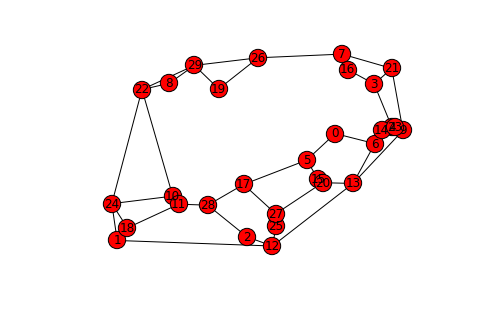

In [202]:
pos = nx.get_node_attributes(G,'pos')

nx.draw(G,pos)
nx.draw_networkx_labels(G,pos)

# Region Enumeration
1. Find a cycle basis, containing $c$ cycles
1. iterate over the $2^{c}-1$ distinct, non-empty Eulerian subgraphs (do this by iterating over the powerset of the cycle basis and finding the symmetric difference of that powerset-element's elements.
  1. check the subgraph for several conditions.    If these conditions are satisfied, we claim that the subgraph is a simply connected region.
    1. Each vertex in the subgraph has degree 2
    1. The edges of the complete graph on the vertices of the subgraph intersect only edges in the subgraph (and no other edges from the graph)

In [203]:
def powerset(iterable):
    """
    Enumerate all non-empty subsets of an iterable.
    For example: powerset([1,2,3]) --> (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)
    """
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(1,len(s)+1,1))

def symmetric_difference_graph(cycle_tuple,graph):
    """
    Given a tuple of lists of nodes, cycle_tuple, an element from the powerset of the cycle basis of a given graph, G, where each list in the given tuple represents a cycle of its contained nodes, return the graph defined by the symmetric difference of the cycles represented by the input tuple's lists.
    """
    G = nx.Graph()
    
    for cycle in cycle_tuple:
        cycle_length = len(cycle)
        cycle_edges = [(cycle[idx],cycle[idx+1]) for idx in range(cycle_length-1)]
        # Close the loop
        cycle_edges.append((cycle[cycle_length-1],cycle[0]))
        
        for edge in cycle_edges:
            i,j = edge
            if G.has_edge(i,j):
                G.remove_edge(i,j)
            else:
                G.add_edge(i,j)
    
    # position the nodes in the symmetric difference graph
    nx.set_node_attributes(G,'pos',{node:(nx.get_node_attributes(graph,'pos'))[node] for node in nx.nodes(G)})
    
    return G

def union(cycle_tuple):

def difference_graph_subgraph(graph,subgraph):
    """
    (should probably be combined with symmetric_difference_graph function) return a subgraph of graph resulting from the removal of edges in cycle from graph
    """
    
    G = nx.Graph()
    G.add_edges_from(graph.edges())
    G.remove_edges_from(subgraph.edges())
    H = nx.Graph()
    H.add_edges_from(G.edges())
    return H
    

class Point:
    def __init__(self,x,y):
        self.x = x
        self.y = y

def ccw(A,B,C):
    return (C.y-A.y) * (B.x-A.x) > (B.y-A.y) * (C.x-A.x)

# Return true if line segments AB and CD intersect
def intersect(A,B,C,D):
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

def edge_intersection(edge1,edge2,graph):
    if edge1[0] != edge2[0] and edge1[0] != edge2[1] and edge1[1] != edge2[0] and edge1[1] != edge2[1]:
        pos = nx.get_node_attributes(graph,'pos')
        A = Point(pos[edge1[0]][0],pos[edge1[0]][1])
        B = Point(pos[edge1[1]][0],pos[edge1[1]][1])
        C = Point(pos[edge2[0]][0],pos[edge2[0]][1])
        D = Point(pos[edge2[1]][0],pos[edge2[1]][1])
        return intersect(A,B,C,D)
    return False

def check_for_regionness(subgraph,graph):
    """
    Given a subgraph and its containing graph (each of which has position data),
    determine whether the subgraph encloses a single, simply connected region in
    the current layout of the graph.
    """
    # Is subgraph connected?
    if nx.number_connected_components(subgraph) != 1:
        return False
    
    # Does each node in subgraph have degree 2?
    for node in subgraph.nodes():
        if subgraph.degree(node) != 2:
            return False
    
    # Does each edge in subgraph intersect only subgraph edges (and no other edges in graph)?
    # This will fail for many non-convex regions, though
    pos = nx.get_node_attributes(graph,'pos')
    for subgraph_edge in combinations(subgraph.nodes(),2):
        for graph_edge in (difference_graph_subgraph(graph,subgraph)).edges():
            if edge_intersection(subgraph_edge,graph_edge,graph):
                return False
    return True

for subset_cycle_basis in powerset(nx.cycle_basis(G)):
    #print("TESTING:",(symmetric_difference_graph(subset_cycle_basis,G)).edges())
    if check_for_regionness(symmetric_difference_graph(subset_cycle_basis,G),G):
        print("Yo got dat face:",(symmetric_difference_graph(subset_cycle_basis,G)).edges())
        print(subset_cycle_basis)

Yo got dat face: [(9, 21), (9, 23), (3, 4), (3, 21), (4, 23)]
([3, 21, 9, 23, 4],)
Yo got dat face: [(26, 19), (26, 29), (19, 29)]
([19, 29, 26],)
Yo got dat face: [(8, 29), (8, 22), (29, 22)]
([8, 22, 29],)
Yo got dat face: [(24, 10), (24, 22), (10, 22)]
([24, 10, 22],)
Yo got dat face: [(24, 18), (24, 10), (18, 11), (11, 10)]
([24, 18, 11, 10],)
Yo got dat face: [(24, 1), (24, 18), (1, 18)]
([24, 1, 18],)
Yo got dat face: [(25, 27), (25, 12), (27, 20), (20, 13), (13, 12)]
([13, 20, 27, 25, 12],)
Yo got dat face: [(1, 18), (1, 12), (2, 12), (2, 28), (28, 11), (11, 18)]
([28, 2, 12, 1, 18, 11],)
Yo got dat face: [(16, 3), (16, 7), (3, 21), (21, 7)]
([3, 16, 7, 21],)
Yo got dat face: [(16, 3), (16, 7), (3, 4), (4, 23), (21, 9), (21, 7), (23, 9)]
([3, 21, 9, 23, 4], [3, 16, 7, 21])
Yo got dat face: [(24, 1), (24, 10), (1, 18), (18, 11), (11, 10)]
([24, 18, 11, 10], [24, 1, 18])
Yo got dat face: [(1, 24), (1, 12), (18, 24), (18, 11), (12, 2), (11, 28), (28, 2)]
([24, 1, 18], [28, 2, 12, 1

# Next Steps
1. since there may exist several minmax length triangulations of a face, one could enumerate all such triangulations and find those that are more ideal with respect to:
  1. daily travel
  1. opponent activity
  1. node degree
1. allow for the input of "layer nodes," which will not be included in the triangulation, but as